In [158]:
import sys
home = '/home/nina/CopulaGP/'
sys.path.insert(0, home)

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import utils

In [159]:
with open(f"{home}MI_dump.pkl","rb") as f:
    data = pkl.load(f)
with open(f"{home}MI_nonlinear.pkl","rb") as f:
    data_nl = pkl.load(f)

In [160]:
layerN = np.array([len(ex[0].layers) for ex in data])
layerN_nl = np.array([len(ex[0].layers) for ex in data_nl])
np.min(layerN)

1

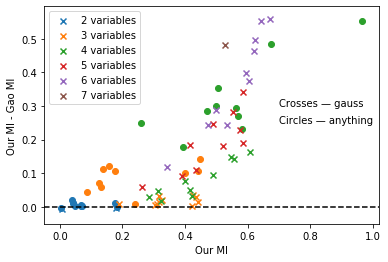

In [168]:
MI_gao = np.array([ex[3] for ex in data])
MI_our = np.array([ex[2][0][0] for ex in data])
MI_gao_nl = np.array([ex[3] for ex in data_nl])
MI_our_nl = np.array([ex[2][0][0] for ex in data_nl])
for i in range(np.min(layerN),np.max(layerN)+1):
    plt.scatter(MI_gao[layerN==i],(MI_our-MI_gao)[layerN==i],label=f'{i+1} variables',
                marker='x',color=f'C{i-1}')
    plt.scatter(MI_gao_nl[layerN_nl==i],(MI_our_nl-MI_gao_nl)[layerN_nl==i],
                marker='o', color=f'C{i-1}')
plt.axhline(0,color='black',linestyle='dashed')
plt.legend()
plt.text(0.7,0.3,'Crosses — gauss')
plt.text(0.7,0.25,'Circles — anything')
plt.xlabel('Our MI')
plt.ylabel('Our MI - Gao MI');

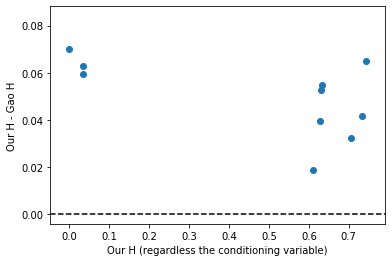

In [83]:
H_gao = np.array([-ex[1][0][1] for ex in data])
H_our = np.array([ex[2][2][0].cpu().numpy() for ex in data])
for i in range(np.min(layerN),np.max(layerN)+1):
    plt.scatter(H_our[layerN==i],(H_our-H_gao)[layerN==i])
plt.axhline(0,color='black',linestyle='dashed')
plt.xlabel('Our H (regardless the conditioning variable)')
plt.ylabel('Our H - Gao H');

In [13]:
n = np.argmax(MI_our-MI_gao)
vine = data[n][0]
print(utils.get_vine_name(vine))

C_01: Gumbel0°
C_02: Clayton0°
C_03: Gumbel180°
C_04: Clayton180°
C_05: Gumbel270°
C_12|0: Gumbel0°
C_13|0: Gumbel270°
C_14|0: Clayton270°
C_15|0: Gumbel0°
C_23|01: Clayton180°
C_24|01: Clayton180°
C_25|01: Gaussian
C_34|012: Clayton270°
C_35|012: Gumbel0°
C_45|0123: Clayton270°



In [69]:
import marginal as mg
import torch
NSamp=10000
device = torch.device('cuda:0')
x = torch.linspace(0.,1.,NSamp).numpy()

V = vine.sample()
y = V.cpu().numpy()
mg.revised_mi(x.reshape((*x.shape,1)),y,k=3)/np.log(2)

array([ 0.55018925, -1.48082153])